In [1]:
import tables as tb
import pandas as pd
import numpy as np
import sys
import os
from   glob import glob

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

from labelling.MClabelling           import labelling_MC
from labelling.beershebalabelling    import labelling_beersheba
from utils.beersheba_labelling_utils import label_neighbours_ordered
from utils.data_utils                import get_event_id 
from utils.histogram_utils           import container_creator, bin_creator

import invisible_cities.io.dst_io as dio

from utils.plotting_utils import plot_cloud_voxels, plot_cloud_voxels_and_hits, plot_3d_hits

# Función final
Junto todo en una función y pruebo el resultado

In [1]:
cutnum, num = '24', '6206'
directory_temp   = '/Users/mperez/NEXT/bersh_prod/prod_example/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut{cut}.beersheba_{num}.root.h5'
directory = directory_temp.format(cut = cutnum, num = num)

total_size  = (440, 440, 550) 
voxel_size  = (5, 5, 2) #equivalent to step
start_bin   = (-220, -220, 0) #equivalent to x0

In [3]:
detector_container = container_creator(total_size, voxel_size)
detector_bins = bin_creator(detector_container, steps = voxel_size, x0 = start_bin)

In [14]:
def label_file(directory, 
               total_size, 
               voxel_size, 
               start_bin, 
               label_neighbours_function,
               blob_ener_loss_th = None, 
               blob_ener_th = None, 
               simple = True, 
               relabel = True,
               binclass = True,
               segclass = True, 
               Rmax = np.nan):
    '''
    Function that performs the whole beersheba labelling. Starting from the MC hits, they are labelled in three
    classes (rest, track, blob) and voxelized with the labelling_MC function. Then, with the labelling_beersheba
    we voxelize the reconstructed hits. These voxels are merged with the MC voxels in order to match information.
    Some corrections are done to those MC voxels that fall outside the beersheba voxels. Once that is done, the
    algorithm labels the empty beersheba voxels as neighbours of one of the main classes. It is also created a new
    ghost class to label those disconnected voxels that arise from the beersheba reconstruction that don't have
    a MC origin, so they don't have main class neighbours to be labelled.
    
    Args: 
        directory: STR
    Contains the directory of a file with several events with Monte Carlo and beersheba hits information.
    
        total_size: TUPLE 
    Contains the max size of the detector.
    
        voxel_size: TUPLE
    Contains the voxel size of the detector for each coordinate.
    
        start_bin: TUPLE
    Contains the first voxel position for each coordinate.
    
        label_neighbours_function: FUNCTION
    Selected function to perform the neighbour labelling (so I can easily change the method)
    
        blob_ener_loss_th: FLOAT
    Energy loss percentage of total track energy for the last hits that establishes a threshold for the blob class.
        
        blob_ener_th: FLOAT
    Energy threshold for the last hits of a track to become blob class.
        
        simple: BOOL
    If True, in the voxelization we will only use hits energy information. Else, the voxelization would include 
    the information of some feature (with its ratio), which in beersheba data it's just the npeak variable. I 
    don't really know if this is an important information.
    
        relabel: BOOL
    If True, the merge_MC_beersh_voxels would try to include the external MC labelled voxels to some empty beersheba
    voxels, so we can benefit from this information. Else, this info will be lost and we would stick only to the 
    true coincident voxels.
    
        binclass: BOOL
    If True, labelling_MC function will be passed. Otherwise, it will return empty dataframes.
    
        segclass: BOOL
    If True, and if binclass is also True (because we need MC labelled voxels information), labelling_beersheba
    will be passed. Otherwise, if False or if binclass False, will return an empty dataframe.
    
        Rmax: NaN or FLOAT
    Value to perform the fiducial cut of the hits. If NaN, the cut is not done.
    
    RETURNS:
        labelled_MC_voxels: DATAFRAME
    If the conditions are satisfied (binclass = True), this contains the labelled MC voxels for each event in 
    the file.
        
        labelled_MC_hits: DATAFRAME
    If the conditions are satisfied (binclass = True), this contains the labelled MC hits for each event in the
    file. We will use them to plot nicer images.
        
        labelled_beersheba: DATAFRAME
    If the conditions are satisfied (binclass and segclas = True), this contains the labelled beersheba voxels
    for each event in the file.
    '''
    
    #Just in case binclass and segclass are False, to return something
    labelled_MC_voxels, labelled_MC_hits, labelled_beersheba = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    if binclass:
        labelled_MC_voxels, labelled_MC_hits = labelling_MC(directory, 
                                                            total_size, 
                                                            voxel_size, 
                                                            start_bin, 
                                                            blob_ener_loss_th = blob_ener_loss_th, 
                                                            blob_ener_th = blob_ener_th, 
                                                            Rmax = Rmax)
    
    if binclass and segclass:
        labelled_beersheba = labelling_beersheba(directory, 
                                                 total_size, 
                                                 voxel_size, 
                                                 start_bin, 
                                                 labelled_MC_voxels, 
                                                 label_neighbours_function, 
                                                 simple = simple, 
                                                 relabel = relabel, 
                                                 Rmax = Rmax)
    
        #Rename to match the names in the next_sparseconvnet functions
        labelled_beersheba = labelled_beersheba.rename(columns={'x': 'xbin', 
                                                                'y': 'ybin', 
                                                                'z': 'zbin', 
                                                                'beersh_ener': 'energy', 
                                                                'ener': 'MC_ener'})
    else:
        print('No labelling has been performed')
        
    return labelled_MC_voxels, labelled_MC_hits, labelled_beersheba

In [5]:
labelled_MC_voxels, labelled_MC_hits, labelled_beersheba = label_file(directory, 
                                                                      total_size, 
                                                                      voxel_size, 
                                                                      start_bin, 
                                                                      label_neighbours_ordered, 
                                                                      blob_ener_losss_th = 0.25, 
                                                                      binclass = True, 
                                                                      segclass = True)

In [6]:
nevent = 34

In [7]:
event_id = get_event_id(cutnum, nevent)

In [8]:
event_beersh = labelled_beersheba[labelled_beersheba.event_id == event_id]

In [9]:
event_hits = labelled_MC_hits[labelled_MC_hits.event_id == event_id]

<IPython.core.display.Javascript object>


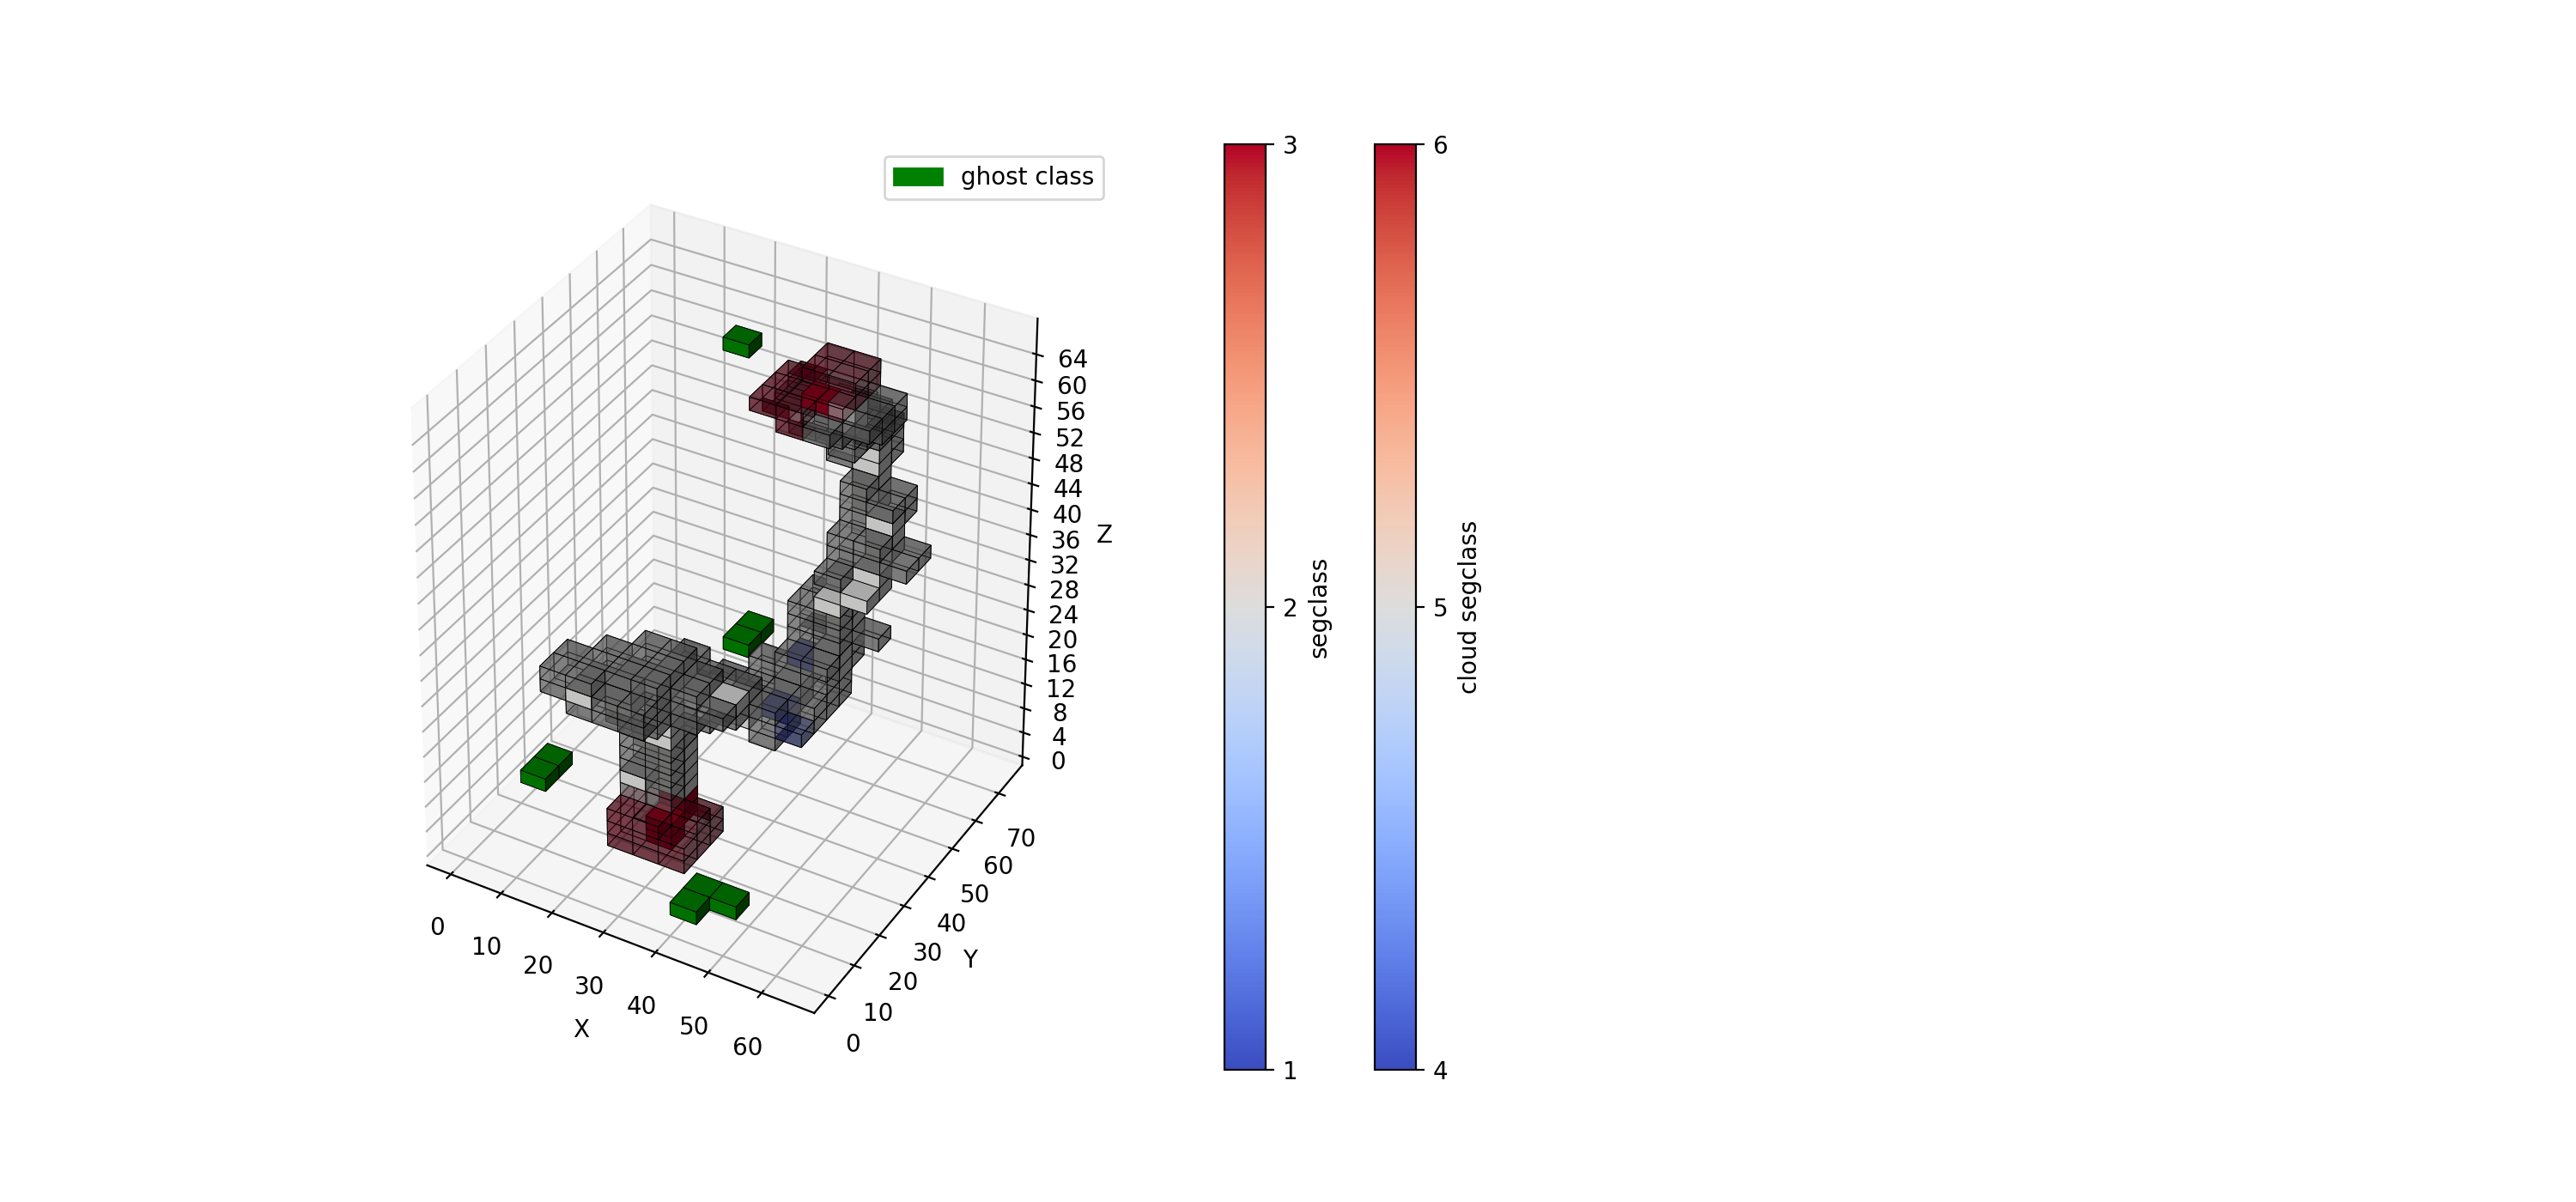

<IPython.core.display.Javascript object>


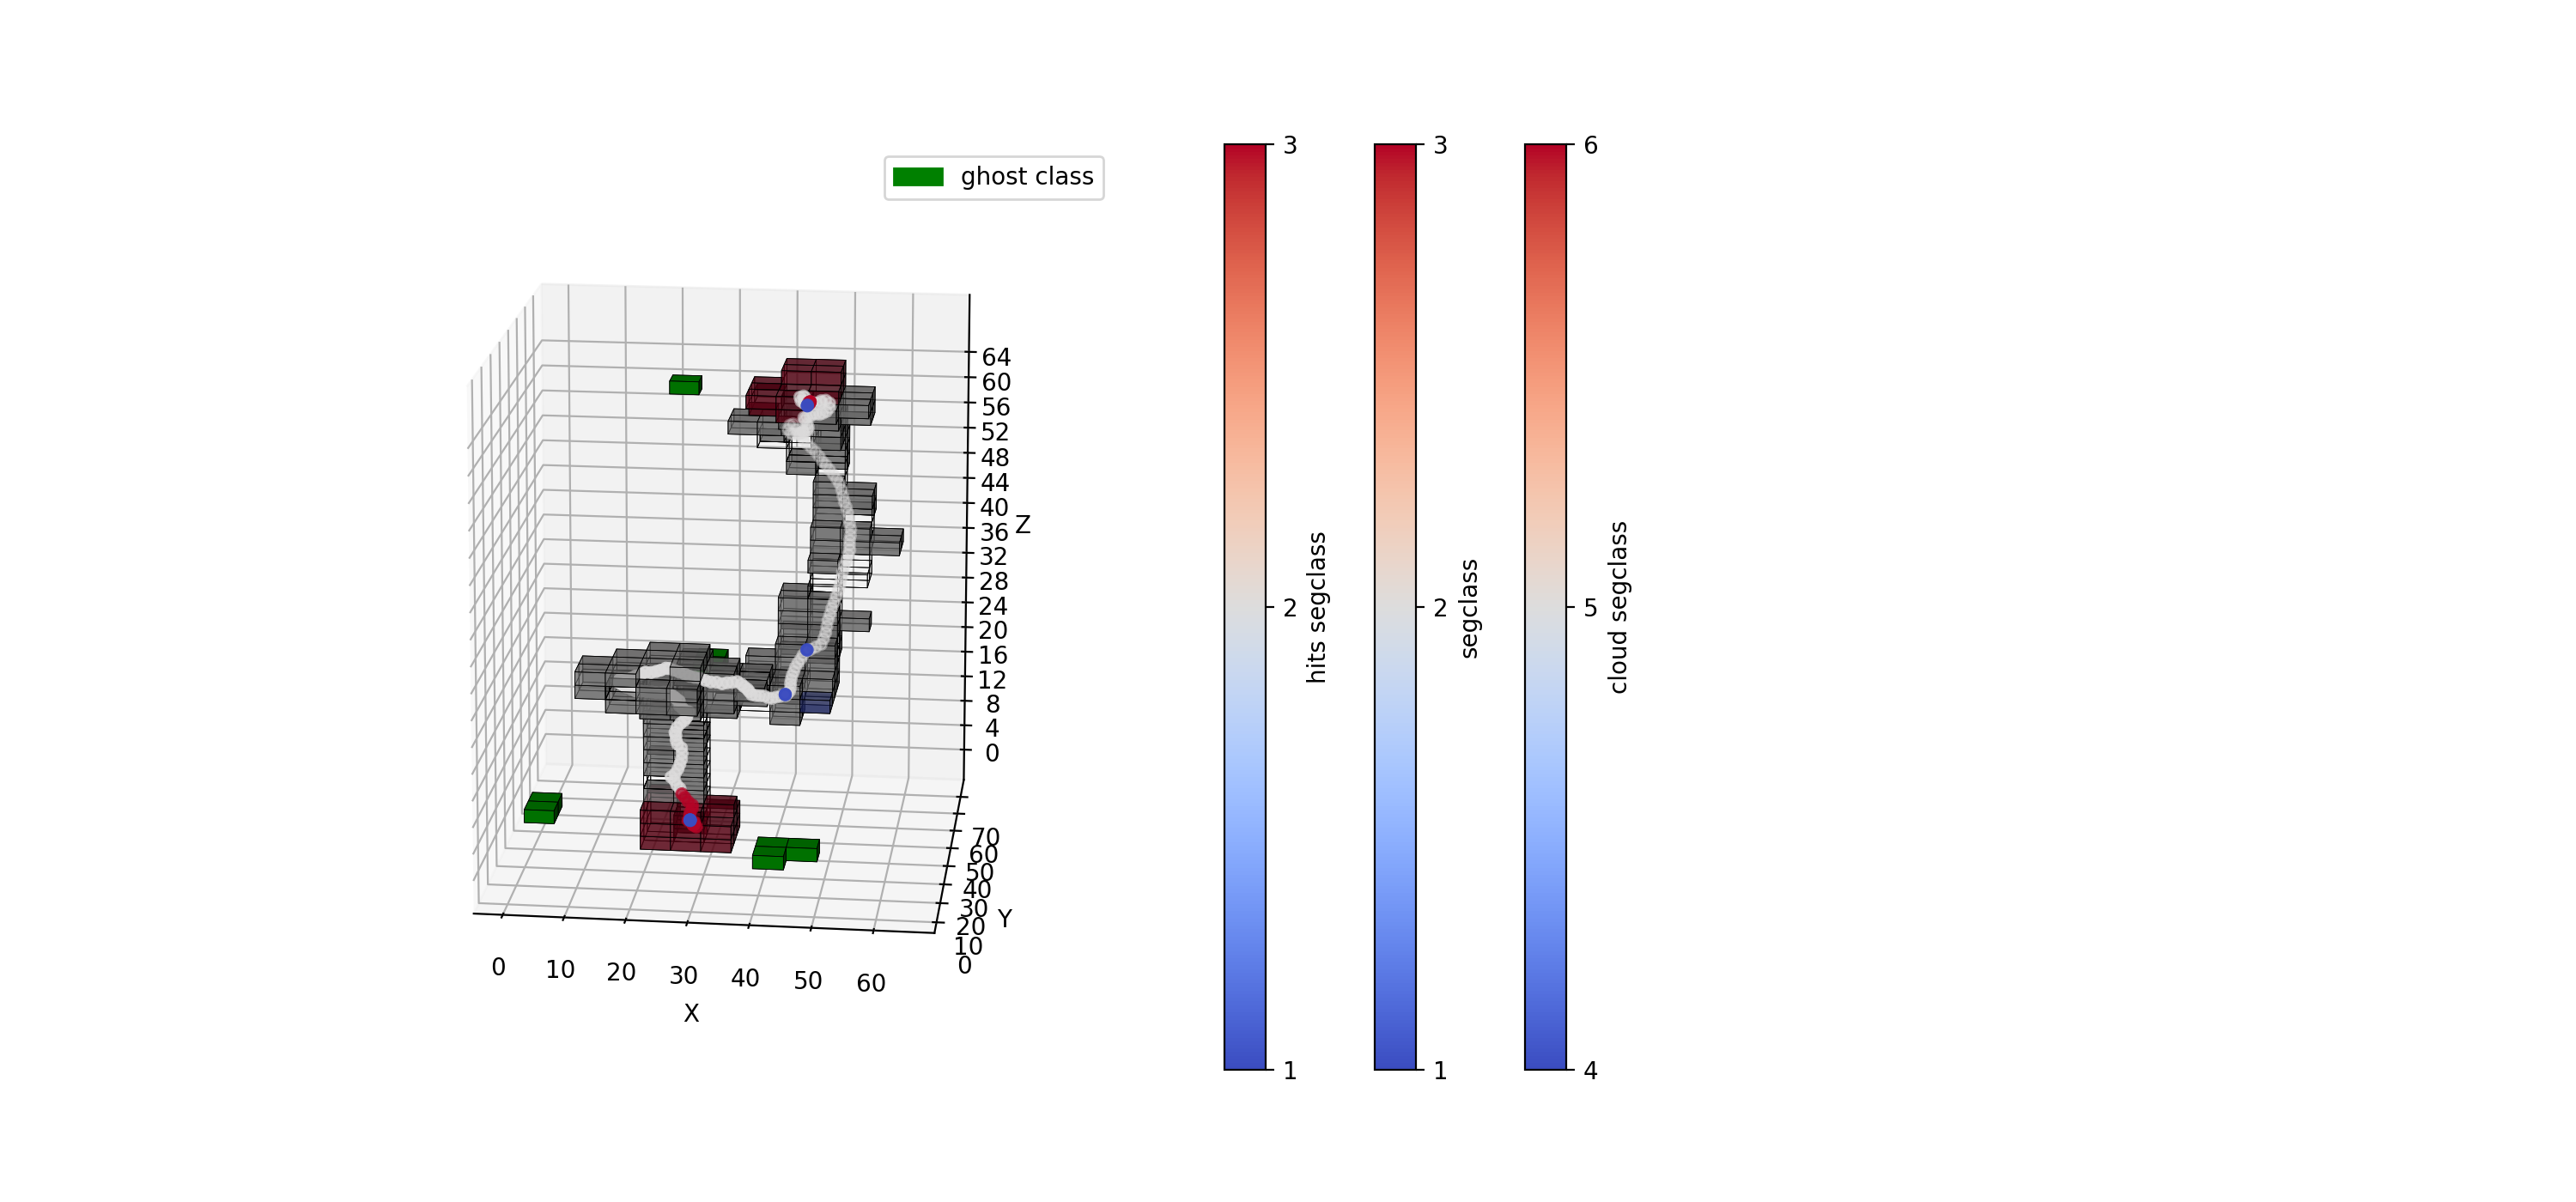

<IPython.core.display.Javascript object>


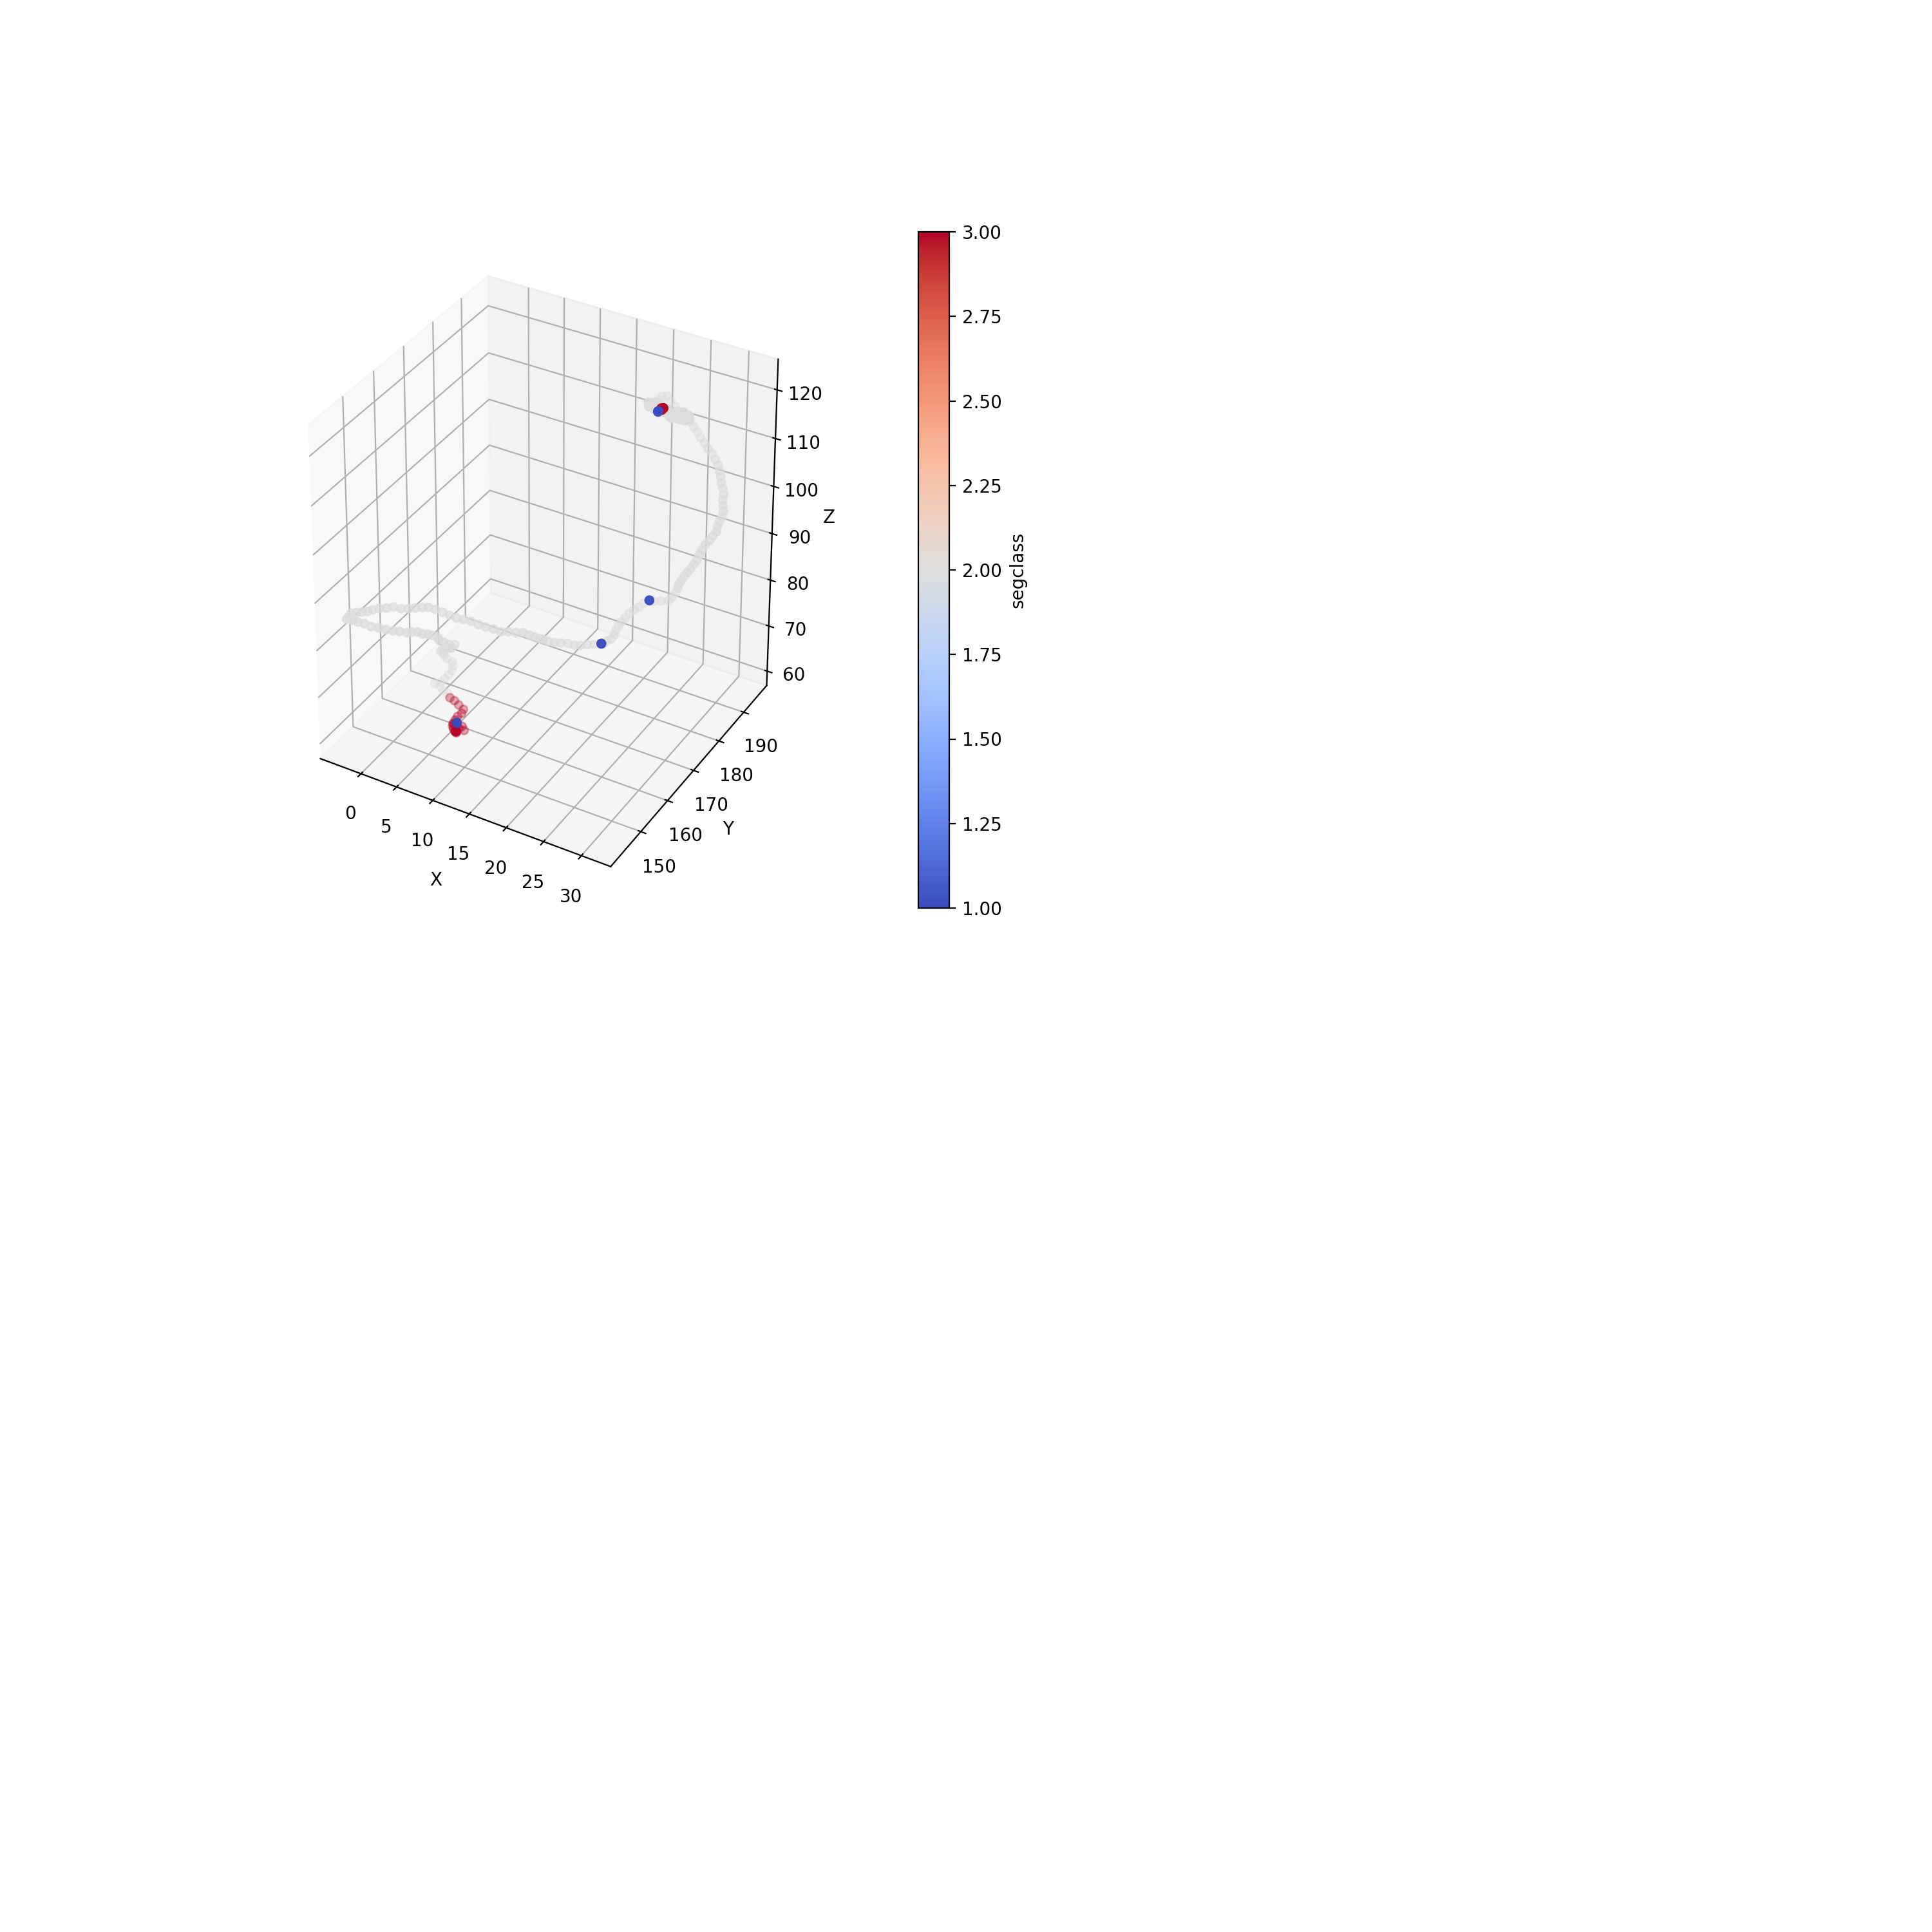

In [10]:
%matplotlib notebook

plot_cloud_voxels(event_beersh, voxel_size, opacity = [1, 0.5])
plot_cloud_voxels_and_hits(event_beersh, event_hits, voxel_size, opacity = [0, 0.6])
plot_3d_hits(event_hits, value = 'segclass', cmap = mpl.cm.coolwarm)

Añadí clase fantasma, cambié la voxelización (a 2mm en z), mejoré los plots. Lo siguiente: empezar la producción :)

# REVISIÓN FUNCIONES (FIDUCIAL CUT AND NEW VOXEL METHOD) 


In [12]:
from invisible_cities.core  .configure import configure
from invisible_cities.cities.components import index_tables
from next_sparseconvnet.data_io_scripts import MC_dataset_table_utils as mcutils
from utils.labelling_utils import add_hits_labels_MC


Primero voy a revisar lo del fiducial cut y el voxelizado rápido que hace marija porque me parece útil. Ver veo que funciona pero necesitaré obtener también el ratio con ese método, que seguro que hay una forma rápida...

In [6]:
mchits = dio.load_dst(directory, 'MC', 'hits')
mcpart = dio.load_dst(directory, 'MC', 'particles')

In [7]:
mchits = mchits[mchits.label == 'ACTIVE']

In [118]:
labelled_hits = add_hits_labels_MC(mchits, mcpart, blob_ener_loss_th = 0.25)

A partir de aqui, Marija con estos hits y con los bins (que ella hace más directa q yo con el bin_creator porque no pasa por tener un container_creator, como tengo ejemplificado en la siguiente casilla con un simple np.arange) pos hace el boundary cut (q es simplemente que los hits estén dentro de los bines... otra cosa es la escogición de dichos bines), el fiducial cut (preguntar si hay un valor fijo para NEW o algo...) y el voxelizado super rapido...

In [9]:
(np.arange(start_bin[2], start_bin[2]+total_size[2] + voxel_size[2], voxel_size[2])  == detector_bins[2]).all()

True

Es True, es decir el método marija y el mío para crear los bines coinciden :)

Bueno, voy a ver un poco lo que hizo :)

In [36]:
Rmax = 198

In [37]:
segclass = 'segclass'
binclass = 'binclass'
fiducial_cut = (labelled_hits.x**2+labelled_hits.y**2)<Rmax**2
binsX, binsY, binsZ = detector_bins
boundary_cut = (labelled_hits.x>=binsX.min()) & (labelled_hits.x<=binsX.max())\
                 & (labelled_hits.y>=binsY.min()) & (labelled_hits.y<=binsY.max())\
                 & (labelled_hits.z>=binsZ.min()) & (labelled_hits.z<=binsZ.max())

In [40]:
sum(fiducial_cut)/len(fiducial_cut)

143266

El fiducial cut elimina muy pocos hits de MC... pero de beersheba quizás son más, no sé si tendré que aplicar el corte en esos!!

Y obviamente el boundary cut tal y como lo tengo yo q es a todo el tamaño del detector pos entra todo... quizás no debería ser a todo el tamaño entonces los bines primero con el boundary cut me quitarían los hits de fuera y luego voxelizan con ese tamaño, por lo que no habría tampoco hits fuera nunca :)

In [13]:
sum(boundary_cut)/len(boundary_cut)

1.0

In [14]:
hits_act = labelled_hits[fiducial_cut & boundary_cut].reset_index(drop = True)

In [15]:
xbin = pd.cut(hits_act.x, binsX, labels = np.arange(0, len(binsX)-1)).astype(int)
ybin = pd.cut(hits_act.y, binsY, labels = np.arange(0, len(binsY)-1)).astype(int)
zbin = pd.cut(hits_act.z, binsZ, labels = np.arange(0, len(binsZ)-1)).astype(int)

In [16]:
hits_act.x

0         26.949236
1         26.678534
2         26.359673
3         25.943626
4         25.443466
            ...    
143232    36.669090
143233    25.682772
143234    25.682297
143235    26.329964
143236    26.328190
Name: x, Length: 143237, dtype: float32

In [17]:
binsX

array([-220., -215., -210., -205., -200., -195., -190., -185., -180.,
       -175., -170., -165., -160., -155., -150., -145., -140., -135.,
       -130., -125., -120., -115., -110., -105., -100.,  -95.,  -90.,
        -85.,  -80.,  -75.,  -70.,  -65.,  -60.,  -55.,  -50.,  -45.,
        -40.,  -35.,  -30.,  -25.,  -20.,  -15.,  -10.,   -5.,    0.,
          5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,   45.,
         50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,   90.,
         95.,  100.,  105.,  110.,  115.,  120.,  125.,  130.,  135.,
        140.,  145.,  150.,  155.,  160.,  165.,  170.,  175.,  180.,
        185.,  190.,  195.,  200.,  205.,  210.,  215.,  220.])

In [18]:
xbin

0         49
1         49
2         49
3         49
4         49
          ..
143232    51
143233    49
143234    49
143235    49
143236    49
Name: x, Length: 143237, dtype: int64

Pfff es un binado super smooth si me preguntan...

In [19]:
hits_act = hits_act.assign(xbin=xbin, ybin=ybin, zbin=zbin)
hits_act.event_id = hits_act.event_id.astype(np.int64)

In [20]:
from sklearn.utils.extmath import weighted_mode

In [50]:
out = hits_act.groupby(['xbin', 'ybin', 'zbin', 'event_id']).apply(
        lambda df:pd.Series({'energy':df['energy'].sum(),
                             segclass:int(weighted_mode(df[segclass], df['energy'])[0][0]),
                             binclass:int(df[binclass].unique()[0])})).reset_index()

hmmm tampoco es como súper inmediato eh... en plan hmmm...

Voy a comparar a ver q pasa, teniendo en cuenta q con mi método ya tengo implementado lo del ratio y no tendría que pensar mucho (aunque el método de marija es mil veces más elegante, en una línea)

In [21]:
from next_sparseconvnet.data_io_scripts.dataset_labeling_utils import get_bin_indices

In [22]:
from time import time

In [41]:
start = time()

mchits = dio.load_dst(directory, 'MC', 'hits')
mcpart = dio.load_dst(directory, 'MC', 'particles')
mchits = mchits[mchits.label == 'ACTIVE']

labelled_hits_prueba1 = add_hits_labels_MC(mchits, mcpart, blob_ener_loss_th = 0.25)

labelled_MC_vox_prueba1 = get_bin_indices(labelled_hits_prueba1, detector_bins, Rmax = 198000)
print(time() - start)

18.564238786697388


In [24]:
start = time()
labelled_MC_voxels, labelled_MC_hits = labelling_MC(directory, 
                                                            total_size, 
                                                            voxel_size, 
                                                            start_bin, 
                                                            blob_ener_loss_th = 0.25)
print(time() - start)

53.44498038291931


La diferencia de tiempo son unos 35 seg por archivo... que como se hace en paralelo pos tampoco no nos va a influir mucho... Es cierto que marija lo tiene más elegante pq lo hace en dos líneas, pero yo además tengo el ratio calculado, lo cual es un puntazo. Si veo rápidamente cómo sacar lo del ratio pruebo a hacerlo si no pepas

Parece q sí es sencillo porque parece que es su segundo argumento de salida!!! Mirar luego bien esto :)

In [46]:
labelled_MC_voxels

,event_id,x,y,z,ener,ratio,segclass,binclass
0,48000024,-1,33,144,0.029452,1.0,1,0
1,48000024,3,32,139,0.004629,1.0,1,0
2,48000024,3,32,140,0.022082,1.0,1,0
3,48000024,3,33,141,0.010240,1.0,1,0
4,48000024,3,33,142,0.017888,1.0,1,0
...,...,...,...,...,...,...,...,...
79,48000597,8,-6,150,0.004106,1.0,2,0
80,48000597,8,-5,150,0.028640,1.0,2,0
81,48000597,8,-4,149,0.011978,1.0,2,0
82,48000597,8,-4,150,0.008966,1.0,2,0


In [48]:
labelled_MC_vox_prueba1.sort_values(['event_id', 'xbin', 'ybin', 'zbin'])

,xbin,ybin,zbin,event_id,energy,segclass,binclass
20766,43,77,144,48000024,0.029452,1,0
25122,47,76,139,48000024,0.004629,1,0
25123,47,76,140,48000024,0.022082,1,0
25161,47,77,141,48000024,0.010240,1,0
25162,47,77,142,48000024,0.017888,1,0
...,...,...,...,...,...,...,...
29538,52,38,150,48000597,0.004106,2,0
29540,52,39,150,48000597,0.028640,2,0
29543,52,40,149,48000597,0.011978,2,0
29544,52,40,150,48000597,0.008966,2,0


In [35]:
detector_bins[0][43]/voxel_size[0] #coincide con el valor de x en el DF calulado por mis métodos asín que...

-1.0

Vale pintaba bonito pero es que el de marija tiene como voxeles las POSICIONES dentro del array de bines, q van de 0 a lo que sea. Yo lo hice con los voxeles escalados por así decirlo, así q van a ir del xbinminimo/voxel_size a xbinmax/voxelsize!! Que la transformación no es que suponga muchísimo pero paso la vd, mejor dejar las cosas como están!!

Algo q veo es q por un mísero voxel no coinciden en número... q está pasando :/ 

AH NADA supongo q cambiarán porque uno tiene cuts hechos y el otro no... cuando haga cuts en mi función pruebo a poner los mismos (aunque en este caso es solo el fiducial, el boundary hice q fuera igual.. así que si pongo rmax enorme sería como no tener fiducial tampoco)

Mmmmm siguen sin coincidir no se muy bien porque

Miraré esto bien cuando aplique yo mis cortes a lo mío, quizás es más relacionado con el boundary cut que en mi código me elimina los que están en el borde pero en el de Marija no o algo así, y coincide que justo hay 2 voxeles en el borde(???) no sé.

Bueno a lo que ibamos, saber si tengo q aplicarle corte fiducial (esto es añadir un par de líneas al código, puedo añadírselas sin saberlo de forma que si tiene valor furrule y si no pues no. Lo del boundary cut es más realmente escoger los límites del detector, pero puede que no valga con hacer un detector container más peque porque los voxeles que se quedan fuera a lo mejor hacen petar o dan algún tipo de fallo, valdría más eliminar antes los hits que no, entonces SÍ O SÍ añadiré la línea que antes de voxelizar me coge los bordes de los bins y elimina todo lo q hay fuera, no es na más ni supone una locura :)

Es decir, añadir boundary cut y la opción del fiducial, luego preguntar por ambos para saber q valores poner etc...

In [119]:
binsX, binsY, binsZ = detector_bins

In [120]:
boundary_cut = (labelled_hits.x>=binsX.min()) & (labelled_hits.x<=binsX.max())\
& (labelled_hits.y>=binsY.min()) & (labelled_hits.y<=binsY.max())\
& (labelled_hits.z>=binsZ.min()) & (labelled_hits.z<=binsZ.max())


In [121]:
Rmax = 207

In [122]:
if np.isnan(Rmax):
    fiducial_cut = pd.Series(np.ones(len(labelled_hits), dtype=bool)) #creates a mask with all trues
else: 
    fiducial_cut = (labelled_hits.x**2+labelled_hits.y**2)<Rmax**2

In [123]:
sum(fiducial_cut)

143266

In [126]:
labelled_hits[boundary_cut & fiducial_cut].reset_index(drop = True)

True

In [125]:
labelled_hits

,event_id,x,y,z,hit_id,energy,segclass,binclass,dist_hits,cumdist,particle_name,creator_proc
0,48000024,26.949236,181.372101,285.124054,0,0.005104,1.0,0,0.0,0.0,gamma,RadioactiveDecay
1,48000024,26.678534,180.700729,285.803558,0,0.003391,1.0,0,0.0,0.0,e-,phot
2,48000024,26.359673,180.022491,286.443512,1,0.004142,1.0,0,0.0,0.0,e-,phot
3,48000024,25.943626,179.287827,286.973358,2,0.006741,1.0,0,0.0,0.0,e-,phot
4,48000024,25.443466,178.509872,287.325806,3,0.004898,1.0,0,0.0,0.0,e-,phot
...,...,...,...,...,...,...,...,...,...,...,...,...
143261,48000597,36.669090,-49.727203,304.841309,9,0.013409,1.0,0,0.0,0.0,e-,eIoni
143262,48000597,25.682772,-62.683788,345.306335,0,0.000678,1.0,0,0.0,0.0,gamma,eBrem
143263,48000597,25.682297,-62.685036,345.305359,0,0.002433,1.0,0,0.0,0.0,e-,phot
143264,48000597,26.329964,-63.877815,345.103729,0,0.000989,1.0,0,0.0,0.0,gamma,phot


Vale, ya están añadidos los cuts, queda preguntar cosas a JA etc

# PREVISIÓN DE PRODUCCIÓN (CONFIG FILES, PROGRAMA DE LANZAMIENTO...)

Partiendo del output de label_file, voy a hacer una reorganización de la información para guardar en unos ficheros, que serán los que use después :)

### ESTOS SON LOS IMPORTS Q TENDRÉ QUE HACER EN EL SCRIPT DE CREACIÓN DEL FILE LABELLEADO

In [25]:
import numpy as np
import pandas as pd
import tables as tb
import os
import invisible_cities.io.dst_io as dio

from invisible_cities.cities.components import index_tables

from labelling.file_labelling import label_file
from utils.beersheba_labelling_utils import label_neighbours_ordered

## CONFIG FILE

In [26]:
#Los datos del config_file:

#Realmente en vez de directory tendré un files_in, y luego tb un file_out en el que escribir coisas!!
cutnum, num = '24', '6206'
directory_temp   = '/Users/mperez/NEXT/bersh_prod/prod_example/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut{cut}.beersheba_{num}.root.h5'
directory = directory_temp.format(cut = cutnum, num = num)



total_size  = (440, 440, 550) 
voxel_size  = (5, 5, 2) #equivalent to step
start_bin   = (-220, -220, 0) #equivalent to x0
blob_ener_loss_th = 0.25
blob_ener_th = None
simple, relabel = True, True
binclass, segclass = True, True
Rmax = np.nan
label_neighbours_name = 'ordered'
#y la función, q puedo hacer q de alguna forma escribiendo label_fun = 'cierto tipo' coja el coso
#y escoja la que yo quiero, q en verdad solo tengo una... pero eso, y en el script pues importar todas y listo

El mapping de funciones ponerlo al principio del script... Por ahora es estúpido pero bueno, en el caso de que tenga más funciones en un futuro...

In [27]:
neighbours_functions_mapping = {'ordered':label_neighbours_ordered}

In [28]:
#labelled_MC_voxels, labelled_MC_hits, labelled_beersheba 
label_file_dfs = label_file(directory, 
                            total_size, 
                            voxel_size, 
                            start_bin, 
                            neighbours_functions_mapping[label_neighbours_name], 
                            blob_ener_loss_th = blob_ener_loss_th, 
                            blob_ener_th = blob_ener_th, 
                            simple = True, 
                            relabel = True,
                            binclass = True, 
                            segclass = True, 
                            Rmax = Rmax)

Para empezar, debería ser indiferente el voxelizado que usemos para crear eventInfo... (aunque no sé por qué, los dataframes si pruebo no me dan iguales, pero columna a columna si...)

In [29]:
start_id = 0

In [49]:
#añadir este import al archivo en el q meta esta función (seguramente en el label files py)
import os

def create_final_dataframes(label_file_dfs, start_id, directory, total_size, voxel_size, start_bin, Rmax): 
    '''
    This function takes the output of label_file function and prepares the data to be saved in a h5 file.
    It will return a dataframe with the bins information of the voxelization of the hits, a dataframe with
    the information of each event, and the dataframes with hits/voxels from the input will have in the output
    an identifier that maps this each hit/voxel with an event in the event info dataframe, so we can track back 
    to its origin data.
    
    Args:
        label_file_dfs: TUPLE OF DATAFRAMES
    It's directly the output of the label_file function, that contains three dataframes: the labelled MC voxels,
    the labelled MC hits and the labelled beersheba voxels.
    
        start_id: INT
    Number to do the mapping between event information and its hits/voxels. It's actualized for every input file
    that we are going to add to the output file in the script that performs the creation of the labelled file.
    
        directory: STR
    Directory of the current file labelled to add its information to the event information df.
    
        total_size: TUPLE 
    Contains the max size of the detector.
    
        voxel_size: TUPLE
    Contains the voxel size of the detector for each coordinate.
    
        start_bin: TUPLE
    Contains the first voxel position for each coordinate.
    
    RETURNS:
        labelled_MC_voxels: DATAFRAME
    If the conditions are satisfied (binclass = True, i.e. the dataframe is not empty), this contains the 
    labelled MC voxels for each event in the file, and it has been added a dataset_id that maps each voxel
    with the event information.
        
        labelled_MC_hits: DATAFRAME
    If the conditions are satisfied (binclass = True, i.e. the dataframe is not empty), this contains the 
    labelled MC hits for each event in the file, and it has been added a dataset_id that maps each hit
    with the event information. We will use them to plot nicer images.
        
        labelled_beersheba: DATAFRAME
    If the conditions are satisfied (binclass and segclas = True, i.e. the dataframe is not empty), this 
    contains the labelled beersheba voxels for each event in the file, and it has been added a dataset_id 
    that maps each voxel with the event information.
    
        eventInfo: DATAFRAME
    Contains the information for each event: its original file directory, its event_id and a dataset_id that 
    maps every hit/voxel with them.
    
        binsInfo: DATAFRAME
    Contains the voxelization information and the value of the fiducial cut.
    '''
    
    labelled_MC_voxels, labelled_MC_hits, labelled_beersheba = label_file_dfs
    if labelled_MC_voxels.empty:
        raise Exception('DataFrames are empty, labelling has not been performed')
    else:
        eventInfo = labelled_MC_voxels[['event_id', 'binclass']].drop_duplicates().reset_index(drop=True)
        dct_map = {eventInfo.iloc[i].event_id : i + start_id for i in range(len(eventInfo))}
        pathname, basename = os.path.split(directory)
        eventInfo = eventInfo.assign(pathname = pathname, basename = basename, dataset_id = eventInfo.event_id.map(dct_map))
        
        labelled_MC_voxels = labelled_MC_voxels.assign(dataset_id = labelled_MC_voxels.event_id.map(dct_map))
        labelled_MC_hits   = labelled_MC_hits.assign(dataset_id   = labelled_MC_hits.event_id.map(dct_map))
        
        labelled_MC_voxels = labelled_MC_voxels.drop('event_id', axis=1)
        labelled_MC_hits   = labelled_MC_hits.drop('event_id', axis=1)
        
        if labelled_beersheba.empty:
            print('Beersheba labelling has not been performed')
        else:
            labelled_beersheba = labelled_beersheba.assign(dataset_id = labelled_beersheba.event_id.map(dct_map))
            labelled_beersheba = labelled_beersheba.drop('event_id', axis=1)
    
    min_x, min_y, min_z       = start_bin[0], start_bin[1], start_bin[2]
    total_x, total_y, total_z  = total_size[0], total_size[1], total_size[2]
    max_x, max_y, max_z       = min_x + total_x, min_y + total_y, min_z + total_z 
    size_x, size_y, size_z    = voxel_size[0], voxel_size[1], voxel_size[2]
    nbins_x, nbins_y, nbins_z = [(total + voxel) / voxel for total, voxel in zip(total_size, voxel_size)] 
    binsInfo = pd.Series({'min_x'   : min_x,
                          'total_x' : total_x, 
                          'size_x'  : size_x,
                          'max_x'   : max_x,
                          'nbins_x' : nbins_x,
                          'min_y'   : min_y,
                          'total_y' : total_y,
                          'size_y'  : size_y,
                          'max_y'   : max_y,
                          'nbins_y' : nbins_y,
                          'min_z'   : min_z,
                          'total_z' : total_z,
                          'size_z'  : size_z,
                          'max_z'   : max_z,
                          'nbins_z' : nbins_z,
                          'Rmax'    : Rmax
                          }).to_frame().T
    return labelled_MC_voxels, labelled_MC_hits, labelled_beersheba, eventInfo, binsInfo

In [31]:
labelled_MC_voxels, labelled_MC_hits, labelled_beersheba, eventInfo, binsInfo = create_final_dataframes(label_file_dfs, 
                                                                                                        start_id, 
                                                                                                        directory, 
                                                                                                        total_size, 
                                                                                                        voxel_size, 
                                                                                                        start_bin)




In [32]:
#eventInfo = labelled_MC_voxels[['event_id', 'binclass']].drop_duplicates().reset_index(drop=True)

In [33]:
#dct_map = {eventInfo.iloc[i].event_id : i+start_id for i in range(len(eventInfo))}

In [34]:
#pathname, basename = os.path.split(directory)

In [35]:
#eventInfo = eventInfo.assign(pathname = pathname, basename = basename, dataset_id = eventInfo.event_id.map(dct_map))
#eventInfo

Puedo borrar el event_id porque con eventInfo ya tengo un mapeo de cual es el evento :)

In [36]:
#labelled_MC_voxels = labelled_MC_voxels.assign(dataset_id = labelled_MC_voxels.event_id.map(dct_map))
#labelled_MC_hits   = labelled_MC_hits.assign(dataset_id   = labelled_MC_hits.event_id.map(dct_map))
#labelled_beersheba = labelled_beersheba.assign(dataset_id = labelled_beersheba.event_id.map(dct_map))

In [37]:
#labelled_MC_voxels = labelled_MC_voxels.drop('event_id', axis=1)
#labelled_MC_hits   = labelled_MC_hits.drop('event_id', axis=1)
#labelled_beersheba = labelled_beersheba.drop('event_id', axis=1)

In [38]:
#labelled_MC_hits

In [39]:
#min_x, min_y, min_z = start_bin[0], start_bin[1], start_bin[2]
#max_x, max_y, max_z = start_bin[0] + total_size[0], start_bin[1] + total_size[1], start_bin[2] + total_size[2]
#nbins_x, nbins_y, nbins_z = [(total + voxel) / voxel for total, voxel in zip(total_size, voxel_size)] 

In [40]:
#update start_id for dataset_id outside the function:
start_id += len(eventInfo)

In [41]:
out_file = '/Users/mperez/NEXT/data_labelling/examples/prueba.h5'

In [42]:
with tb.open_file(out_file, 'a') as h5out:
    dio.df_writer(h5out, labelled_MC_hits  , 'DATASET', 'MCHits'         , columns_to_index=['dataset_id'])
    dio.df_writer(h5out, labelled_MC_voxels, 'DATASET', 'MCVoxels'       , columns_to_index=['dataset_id'])
    dio.df_writer(h5out, labelled_beersheba, 'DATASET', 'BeershebaVoxels', columns_to_index=['dataset_id'])
    dio.df_writer(h5out, eventInfo         , 'DATASET', 'EventsInfo'     , columns_to_index=['dataset_id'], str_col_length=128)
    dio.df_writer(h5out, binsInfo          , 'DATASET', 'BinsInfo')
index_tables(out_file)

In [13]:
with tb.open_file(out_file, 'a') as h5out:
    print(h5out)

/Users/mperez/NEXT/data_labelling/examples/prueba.h5 (File) ''
Last modif.: 'Wed Dec 15 10:56:02 2021'
Object Tree: 
/ (RootGroup) ''
/DATASET (Group) ''
/DATASET/BeershebaVoxels (Table(173852,), shuffle, zlib(4)) ''
/DATASET/BinsInfo (Table(1,), shuffle, zlib(4)) ''
/DATASET/EventsInfo (Table(571,), shuffle, zlib(4)) ''
/DATASET/MCHits (Table(143266,), shuffle, zlib(4)) ''
/DATASET/MCVoxels (Table(43125,), shuffle, zlib(4)) ''



In [43]:
dio.load_dst(out_file, 'DATASET', 'EventsInfo')

,event_id,binclass,pathname,basename,dataset_id
0,48000024,0,/Users/mperez/NEXT/bersh_prod/prod_example,Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersh...,0
1,48000025,0,/Users/mperez/NEXT/bersh_prod/prod_example,Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersh...,1
2,48000026,0,/Users/mperez/NEXT/bersh_prod/prod_example,Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersh...,2
3,48000027,0,/Users/mperez/NEXT/bersh_prod/prod_example,Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersh...,3
4,48000028,0,/Users/mperez/NEXT/bersh_prod/prod_example,Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersh...,4
...,...,...,...,...,...
566,48000592,1,/Users/mperez/NEXT/bersh_prod/prod_example,Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersh...,566
567,48000593,0,/Users/mperez/NEXT/bersh_prod/prod_example,Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersh...,567
568,48000595,1,/Users/mperez/NEXT/bersh_prod/prod_example,Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersh...,568
569,48000596,0,/Users/mperez/NEXT/bersh_prod/prod_example,Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersh...,569


In [44]:
dio.load_dst(out_file, 'DATASET', 'BeershebaVoxels')

,xbin,ybin,zbin,energy,binclass,MC_ener,ratio,segclass,dataset_id
0,-1,32,144,0.000357,0,NaN,NaN,4,0
1,-1,33,144,0.000561,0,0.029452,1.0,1,0
2,-1,33,145,0.002432,0,NaN,NaN,4,0
3,0,32,144,0.001903,0,NaN,NaN,4,0
4,0,32,145,0.000442,0,NaN,NaN,4,0
...,...,...,...,...,...,...,...,...,...
173847,8,-5,151,0.000654,0,NaN,NaN,5,570
173848,8,-4,149,0.000611,0,0.011978,1.0,2,570
173849,8,-4,150,0.005414,0,0.008966,1.0,2,570
173850,9,-5,149,0.000636,0,NaN,NaN,5,570


El start_id me hará un mapeo entre el event_id y un numerincho q yo ponga. el cual irá de 0 al número de eventos en una file (si la producción la hago file a file). Si cojo muchas files para hacer la producción (imagínate, todas las de cierto cut, q suelen ser 4 o 5) pues irá de 0 al nº eventos de la primera file, luego de nº de eventos de la primera hasta el nºev primera + segunda... etc y al final el último evento será el número de eventos de todas las files sumado

De hecho, quizá esto del dictionario esté hecho para juntar files con el mismo cutnum porque los event_id van a estar igual numerados (solo que según el número de eventos en el fichero, llegará a un número más alto o más bajo)

Vale, el start_id me creará el dataset_id que será un id para cada evento dentro de un fichero (que en principio juntará distintos ficheros, mi idea es q junte los del mismo cutnum :))

Pero lo más importante es que eventInfo me hace un map del nombre del fichero del que vienen, además del dataset_id. El dataset_id me servirá ahora para mapear con el DataFrame de eventInfo cual es mi evento (fichero del que viene y event_id). No me deshago del event_id en principio en los labelled hits porque lo uso en funciones más adelante...

Vale, creo q aquí lo que me falla es que no sólo voy a hacer MC, tb voy a hacer beersheba. Entonces pienso que esto que estoy haciendo debería ir FUERA quizás de las funciones de label. Es decir, hacemos el label y una vez tenemos los voxeles MC, hits MC y voxeles beersheba, ahí hacerle la identificación!!! 

Rollo Marija se la hace a los voxeles MC, yo se lo puedo hacer a los voxeles MC y a los beersheba guesseo, total es como una correspondencia entre event_id, un dataset_id asignado por mi y el fichero de origen :)